In [12]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.pyplot import figure
import seaborn as sns
import pickle

# importing the models
from sklearn.linear_model import LinearRegression
from sklearn.linear_model import RidgeClassifier
from sklearn.ensemble import RandomForestRegressor
from sklearn.tree import DecisionTreeRegressor
from sklearn.tree import DecisionTreeClassifier
from sklearn.naive_bayes import BernoulliNB
from xgboost import XGBRegressor

# addition predifined 'functions' for splitting the data and evaluating the model
from sklearn.preprocessing import PolynomialFeatures
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error
from sklearn.metrics import r2_score
from sklearn.model_selection import RandomizedSearchCV

import warnings
warnings.filterwarnings("ignore")
pd.set_option('display.max_columns', 100)

# Support functions

In [13]:
class support_functions():
    
    def deleting_irrevelant_columns(self,df, column1 , column2):

        df2 = df.copy()

        del df2[column1]
        del df2[column2]

        return df2

    def missing_weather_data(self,df, columns, method = "mean"):

        df2 = df.copy()

        if method == "mean":

            for x in range(len(columns)):
                df2 = df2.fillna({ columns[x] : df2[columns[x]].mean()})

        return df2
    
    def categorical_to_numerical_convert(self,df,cat_columns):
    
        df2 = df.copy()

        for column in cat_columns:
            one_hot = pd.get_dummies(df2[column])
            # Drop column as it is now encoded
            df2 = df2.drop(column,axis = 1)
            # Join the encoded df
            df2 = df2.join(one_hot)

        return df2
    
    # no need for standardization or normalization
    # no need for outlier detection
    
    def get_top_correlation(self,df):
        cor = df.corr().abs()
        cor2 = cor.unstack()
        cor3 = cor2.sort_values(kind="quicksort", ascending = False)

        return pd.DataFrame(cor3)

    def evaluate_prediction(self,y_prediction,y_val):
        
        mse = mean_squared_error(y_val, y_prediction)
        rmse = mean_squared_error(y_val, y_prediction, squared=False)
        rx = r2_score(y_val, y_prediction)
        print('model mean squared error:',mse)
        print('model root mean squared error:',rmse)
        print('model R2:',rx)


    def try_models(self,model_type,X_train,y_train,X_val,y_val):
        model = model_type
        model.fit(X_train, y_train)
        print('='*20)
        print(f'{model_type}')
        print(f'accuracy of train set: {model.score(X_train, y_train)}')
        print(f'accuracy of val set: {model.score(X_val, y_val)}')
        y_prediction = model.predict(X_val).round(0).astype(int)
        self.evaluate_prediction(y_prediction,y_val)
    

# Problem context.

# ----------- Exploratory Data Analysis ---------

### Data Collection

In [14]:
df_train = pd.read_csv("data/data_train.csv")
df_weather = pd.read_csv("data/weather.csv")
df_train_full = df_train.merge(df_weather, on='date')

# initializing support functions class
support_functions = support_functions()

### Basic check for missing anomalies

In [15]:
print ('Good day Sir')
print ("Total train sample size:", len(df_train_full))
print ("Average visitor count per day:", round(df_train_full['label'].mean(),1))
print ("In the following table, you can see the basic characteristic of the features:")

#Dataframe summary
pd.DataFrame({'unicos':df_train_full.nunique(),
              'missing': df_train_full.isna().sum()/df_train_full.count(),
              'tipo':df_train_full.dtypes,
              'max': df_train_full.max(),
              'min': df_train_full.min()})

Good day Sir
Total train sample size: 1743
Average visitor count per day: 1119.4
In the following table, you can see the basic characteristic of the features:


,unicos,missing,tipo,max,min
date,1743,0.000000,object,2009-12-31,2005-03-20
bank_holiday,3,0.000000,int64,3,0
feature_0,2,0.000000,int64,1,0
feature_1,2,0.000000,int64,1,0
feature_2,2,0.000000,int64,1,0
feature_3,3,0.000000,float64,4.6,3.2
feature_4,3,0.000000,float64,7.6,6.7
feature_5,3,0.000000,float64,2.6,1.7
feature_6,3,0.000000,float64,4.6,3.7
feature_7,2,0.000000,int64,1,0


<ol>
  <li>As we can see feature_8 and feature_9 are irrelevant because they are populated with 0 in all cases.
</li>
  <li>Several columns have missing values but the share of missing values are low so we will keep all columns and impute null values.</li>
</ol>
  <li>Interesting note: Bank holiday feature has only 3 unique values but 4 were given in the description.</li>

## Lets analys the correlation between the features

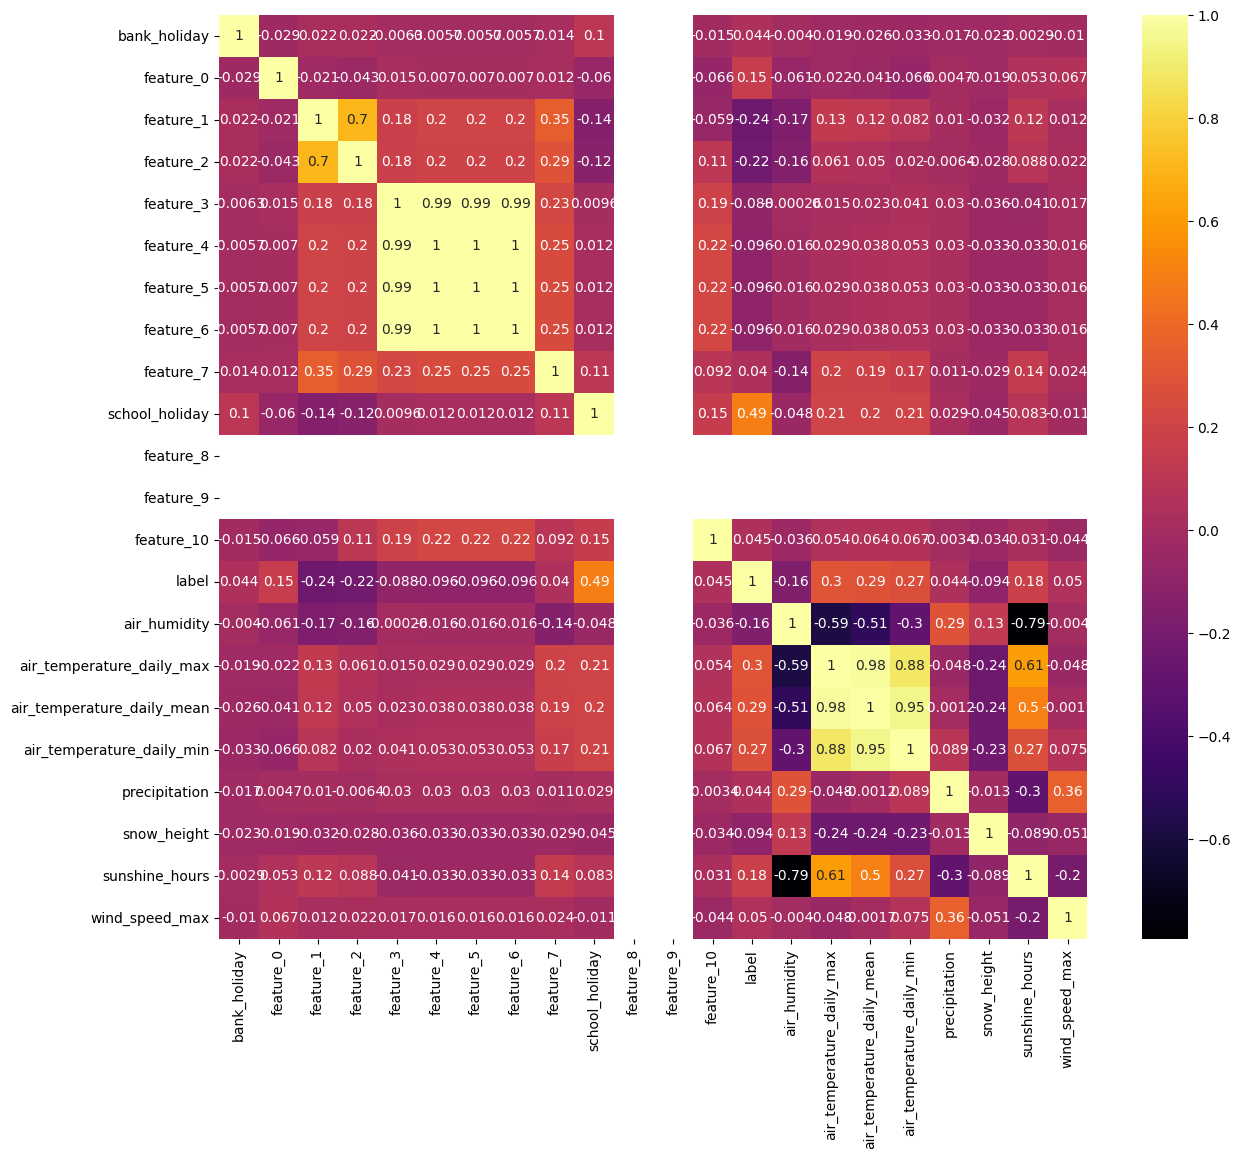

In [21]:
# Dataframe correlation
del_corr = df_train_full.drop('date', axis=1).corr()

# Draw the figure
f, ax = plt.subplots(figsize=(14, 12))

# Draw the heatmap
sns.heatmap(del_corr,annot=True,cmap='inferno')
plt.show()

<ol> Among other things we can see that the school holiday status and the daily max air temperature have the biggest impact on the number of visitors. </ol>

## How is a standard day looks like?

Median 930.0 -- true average visitor count
Mean 1119.4400458978773 -- mean is skewed by huge visitor count on special events
Mode 609 -- most likely visitor count


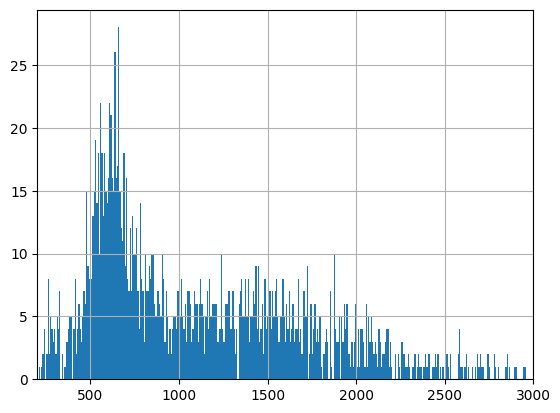

In [22]:
print ("Median", df_train_full["label"].median(), "-- true average visitor count")
print ("Mean", df_train_full["label"].mean(), "-- mean is skewed by huge visitor count on special events")
print ("Mode", df_train_full["label"].mode()[0], "-- most likely visitor count")

plt.xlim(xmin=200, xmax = 3000)
df_train_full['label'].hist(bins = 500)
plt.show()

<ol> The visitor's distribution looks normal with a long tail. </ol>

## How school holiday effects visitor count?

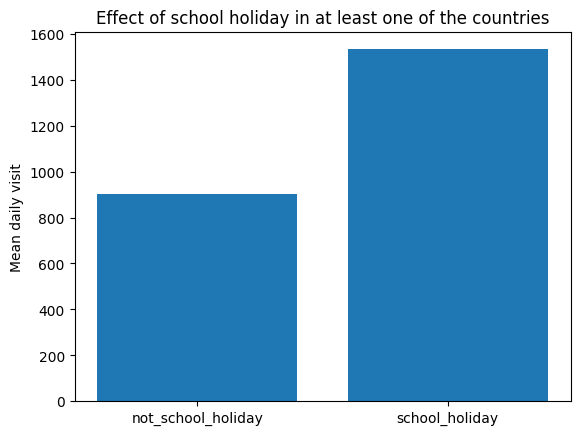

In [23]:
df_train_full_pre = df_train_full.copy()
df_train_full_pre['holiday'] = np.where(df_train_full_pre['school_holiday'] > 0,'school_holiday','not_school_holiday')

holiday_effect = pd.DataFrame(df_train_full_pre.groupby('holiday')\
                    ['label'].mean())

#visualization
plt.bar(holiday_effect.index, holiday_effect['label'])
plt.title('Effect of school holiday in at least one of the countries')
plt.ylabel('Mean daily visit')
plt.show()

<ol> Having a school holiday in at least one of the countries has a great positive impact on the number of visitors. </ol>

## How weekday influence visit numbers?

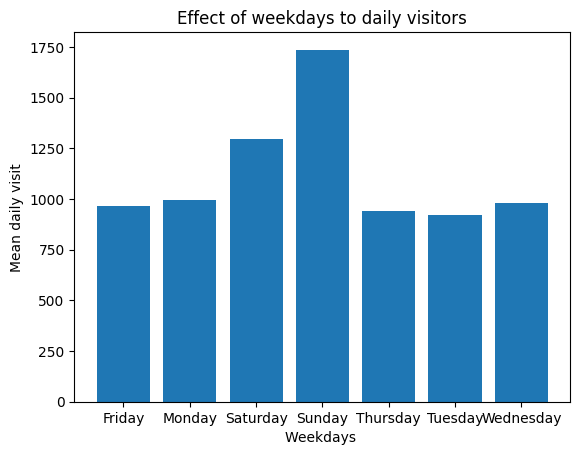

In [24]:
df_train_full_time = df_train_full.copy()
df_train_full_time["date"] = pd.to_datetime(df_train_full_time["date"])
df_train_full_time["weekday"] = df_train_full_time["date"].dt.day_name().astype('category')

dayofweek_effect = pd.DataFrame(df_train_full_time.groupby('weekday')\
                                ['label'].mean())

# visualization
plt.bar(dayofweek_effect.index, dayofweek_effect['label'])
plt.title('Effect of weekdays to daily visitors')
plt.xlabel('Weekdays ')
plt.ylabel('Mean daily visit')
plt.show()

<ol> We can clearly see that weekends have a positive influence on daily visitor counts. </ol>

## How months influence visit numbers?

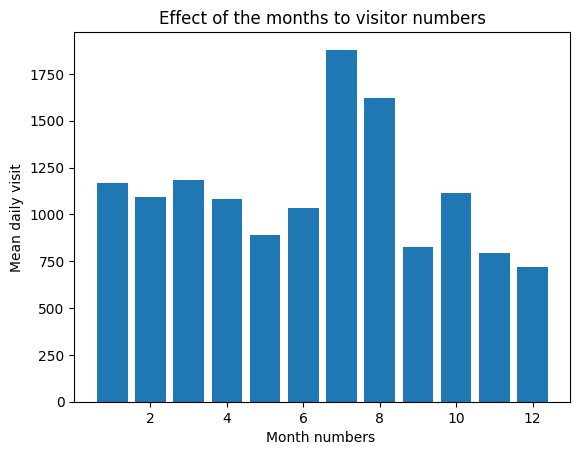

In [25]:
df_train_full_time["month_num"] = df_train_full_time["date"].dt.month.astype('category')

month_effect = pd.DataFrame(df_train_full_time.groupby('month_num')\
                                ['label'].mean())

#visualization
plt.bar(month_effect.index, month_effect['label'])
plt.title('Effect of the months to visitor numbers')
plt.xlabel('Month numbers ')
plt.ylabel('Mean daily visit')
plt.show()

<ol> During the summer months, there is a huge spike in the number of visits. However, this is most likely because of the school holidays. </ol>

## What distibution does the daily visitor count show in regards of time

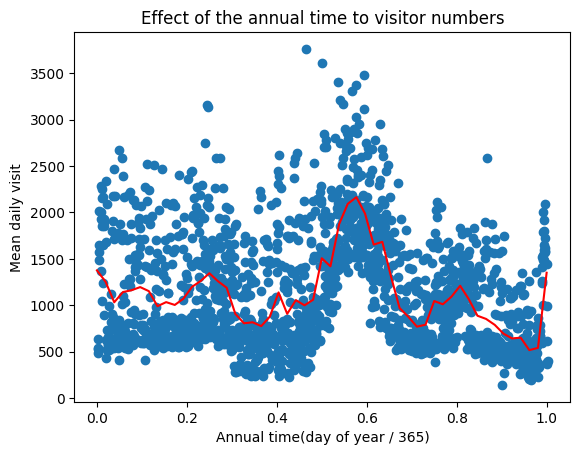

In [26]:
df_train_full_time['annual'] = (df_train_full_time["date"].dt.dayofyear)/365
df_train_full_time['week'] = round((df_train_full_time["date"].dt.dayofyear)/7,0)
weekly_effect = pd.DataFrame(df_train_full_time.groupby("week")['label'].mean())

#visualization
plt.scatter(df_train_full_time["annual"],df_train_full_time['label'])
plt.plot((weekly_effect.index)/52, weekly_effect['label'], color = 'red')
plt.title('Effect of the annual time to visitor numbers')
plt.xlabel('Annual time(day of year / 365)')
plt.ylabel('Mean daily visit')
plt.show()

<ol> Summertime has a positive impact on the visit count, but it again strongly correlates with school holidays. </ol>
<ol> Interesting note: The daily visit count looks somewhat like a quadratic function. </ol>

# -------------------- Data Preparation ---------------------

<ol> During data preparation we need to get rid of unnecessary columns and impute missing values.</ol>
<ol> Based on the EDA we will add a weekend flag and an annual/scaled dayofyear column.</ol>

In [27]:
missing_value_columns = ["air_temperature_daily_max","air_temperature_daily_mean","air_humidity",
                         "air_temperature_daily_min","sunshine_hours","wind_speed_max"]

In [28]:
df_train2 = support_functions.deleting_irrevelant_columns(df_train_full, "feature_8", "feature_9")
df_train3 = support_functions.missing_weather_data(df_train2, missing_value_columns)
df_train3["date"] = pd.to_datetime(df_train3["date"])
df_train3["weekend"] = (df_train3["date"].dt.day_of_week >=5).astype('int')
df_train3['annual'] = (df_train3["date"].dt.dayofyear)/365

# ----------------------- Feature Engineering ----------

<ol> During future engineering we need to treat the categorical features in our dataset. Even when a feature seems numerical the relationship between the numbers might mislead the algorithm, therefore, we first transform them into categorical features and then separate them with the python's get_dummies function.</ol>

In [29]:
school_dict = {0:"no_school_holiday",
               1: "school_holiday_country1",
               2: "school_holiday_country2",
               3: "school_holiday_country12"}

bank_dict = {0:"no_bank_holiday",
             1: "bank_holiday_country1",
             2: "bank_holiday_country2",
             3: "bank_holiday_country12"}

In [30]:
df_train3["school_holiday"].replace(school_dict, inplace = True)
df_train3["bank_holiday"].replace(bank_dict, inplace = True)
df_train4 = support_functions.categorical_to_numerical_convert(df_train3,["school_holiday","bank_holiday"])

# --------------------------- Modelling --------------------

# Creating a simple base-line model

In [31]:
#creating a copy of the prepared dataset
df_basemodel_dataset = df_train4.copy()

# no weekend and annual time data
#selectiong train features(X_train) and train targets(y_train)
train_feature = ['feature_0', 'feature_1', 'feature_2', 'feature_3', 'feature_4',
                'feature_5', 'feature_6', 'feature_7', 'feature_10',
                'air_humidity', 'air_temperature_daily_max',
                'air_temperature_daily_mean', 'air_temperature_daily_min',
                'precipitation', 'snow_height', 'sunshine_hours', 'wind_speed_max',
                'no_school_holiday', 'school_holiday_country1',
                'school_holiday_country12', 'school_holiday_country2',
                'bank_holiday_country12', 'bank_holiday_country2', 'no_bank_holiday']

train_target = 'label'

#separating X_train and y_train datasets
train_df = df_basemodel_dataset[train_feature]
target_df = df_basemodel_dataset[train_target]

#splitting the dataframes into train and val datasets
X_train, X_val, y_train, y_val = train_test_split(train_df, target_df, test_size=0.2, random_state=0)

accuracy of train set: 0.386504609578901
accuracy of val set: 0.4329744913153407
model root mean squared error: 458.43642636690345


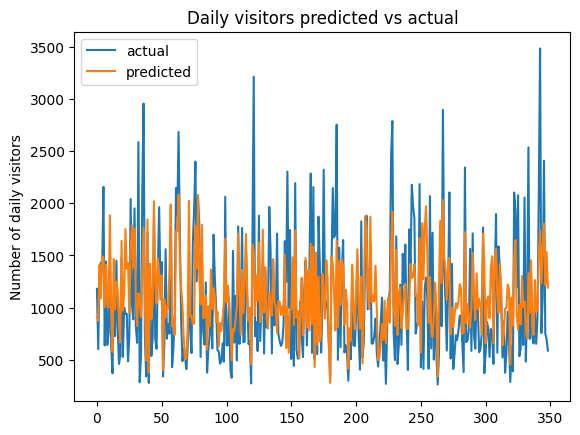

In [32]:
# choose a simple regression model
lr = LinearRegression()
lr.fit(X_train, y_train)
y_prediction = lr.predict(X_val).round(0).astype(int)
rmse = mean_squared_error(y_val, y_prediction, squared=False)
print(f'accuracy of train set: {lr.score(X_train, y_train)}')
print(f'accuracy of val set: {lr.score(X_val, y_val)}')
print('model root mean squared error:',rmse)

plt.title("Daily visitors predicted vs actual")
plt.ylabel("Number of daily visitors")
plt.plot(y_val.values, label='actual')
plt.plot(y_prediction, label='predicted')
plt.legend()
plt.show()

# Finding the best model

<ol>
  <li>The dataset is clean and does not contain many outliers therefore there is no need to use any outlier detection method.</li>
  <li>There are no irrelevant features and getting rid of less correlating features does not improve the model.</li>
  <li>The models which we are going to use do not require normalization or standardization.</li>
</ol>

In [33]:
#creating a copy of the prepared dataset
df_model_dataset = df_train4.copy()

#selectiong train features(X_train) and train targets(y_train)
train_feature = ['feature_0', 'feature_1', 'feature_2', 'feature_3', 'feature_4',
                'feature_5', 'feature_6', 'feature_7', 'feature_10',
                'air_humidity', 'air_temperature_daily_max',
                'air_temperature_daily_mean', 'air_temperature_daily_min',
                'precipitation', 'snow_height', 'sunshine_hours', 'wind_speed_max',
                'weekend', 'annual', 'no_school_holiday', 'school_holiday_country1',
                'school_holiday_country12', 'school_holiday_country2',
                'bank_holiday_country12', 'bank_holiday_country2', 'no_bank_holiday']

train_target = 'label'

#separating X_train and y_train datasets
train_df = df_model_dataset[train_feature]
target_df = df_model_dataset[train_target]

#splitting the dataframes into train and val datasets
X_train, X_val, y_train, y_val = train_test_split(train_df, target_df, test_size=0.2, random_state=0)

In [34]:
models = [LinearRegression(),RidgeClassifier(),
          RandomForestRegressor(),DecisionTreeRegressor(),
          DecisionTreeClassifier(),BernoulliNB(),XGBRegressor()]

print('start model trials')
for modelx in models:
    support_functions.try_models(modelx,X_train,y_train,
                      X_val,y_val)

start model trials
LinearRegression()
accuracy of train set: 0.5762114899429878
accuracy of val set: 0.6077698149737832
model mean squared error: 145357.05444126076
model root mean squared error: 381.25720247788206
model R2: 0.6078154669562632
RidgeClassifier()
accuracy of train set: 0.12625538020086083
accuracy of val set: 0.0
model mean squared error: 236915.48424068769
model root mean squared error: 486.739647286604
model R2: 0.3607837685283314
RandomForestRegressor()
accuracy of train set: 0.9642167296332314
accuracy of val set: 0.7538869826996748
model mean squared error: 91213.62464183381
model root mean squared error: 302.01593441709963
model R2: 0.753898612455441
DecisionTreeRegressor()
accuracy of train set: 1.0
accuracy of val set: 0.5989697092410553
model mean squared error: 148635.59598853867
model root mean squared error: 385.5328727729176
model R2: 0.5989697092410553
DecisionTreeClassifier()
accuracy of train set: 1.0
accuracy of val set: 0.0
model mean squared error: 230

## Model1: Polynomial LinearRegression

<ol>After seeing how well a simple linear regression model performed and based on the distribution of the dataset we can expect a 2nd-degree polynomial linear regression to overperform it.</ol>

In [35]:
#we have to transform the dataset into intigers(to weaken negative numbers impact) and then apply the polynomial fuction
poly = PolynomialFeatures(degree = 2)
X_train_poly_train = poly.fit_transform(X_train.astype('int16'))
X_val_poly_val = poly.transform(X_val.astype('int16'))

LinearRegression
accuracy of train set: 0.7654048436247216
accuracy of val set: 0.6622444944114865
model mean squared error: 125175.10601719198
model root mean squared error: 353.8009412327672
model R2: 0.6622679188790881


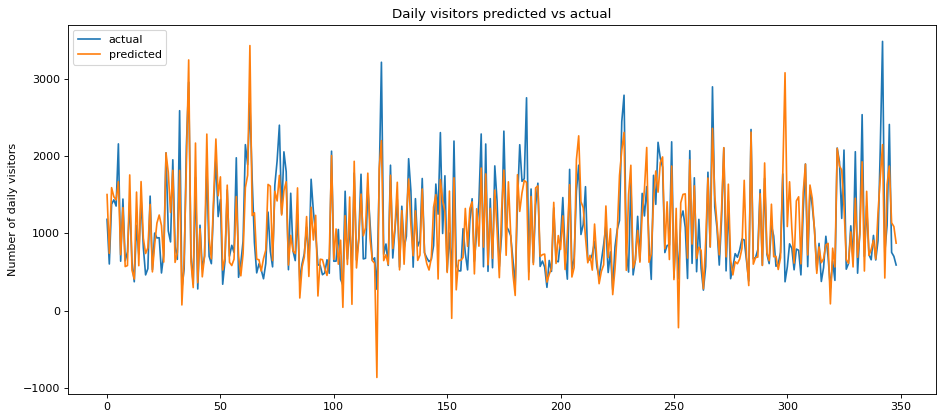

In [36]:
# # LinearRegression==============
pln = LinearRegression()
pln.fit(X_train_poly_train, y_train)
print('='*20)
print('LinearRegression')
print(f'accuracy of train set: {pln.score(X_train_poly_train, y_train)}')
print(f'accuracy of val set: {pln.score(X_val_poly_val, y_val)}')

y_prediction = pln.predict(X_val_poly_val).round(0).astype(int)
#print model metrics
support_functions.evaluate_prediction(y_prediction,y_val)

#visualize prediction
figure(figsize=(14, 6), dpi=80)
plt.title("Daily visitors predicted vs actual")
plt.ylabel("Number of daily visitors")
plt.plot(y_val.values, label='actual')
plt.plot(y_prediction, label='predicted')
plt.legend()
plt.show()

<ol> Even though this 2nd-degree linear regression model turned out to be a massive improvement on the base-line model, the Random Forest Regression still outperformed this model.</ol>

## Model2: RandomForest Regression

<ol> 
    <li>Out of all the models we have tested the XGBoost and the Random Forest Regression performed the best.</li>
    <li>We are going to use Random Forest Regression because I expect most of the candidates to use XGBoost but the difference between the two models shall be insignificant.</li>
    <li>We going to maximise the performance of the model by finding the best parameters. </li>
</ol>

### Hyperparameter Tuning

In [37]:
# number of trees in the random forest
n_estimators = [5,20,50,100] 
# number of features in consideration at every split
max_features = ['auto', 'sqrt'] 
# maximum number of levels allowed in each decision tree
max_depth = [int(x) for x in np.linspace(10, 120, num = 12)] 
# minimum sample number to split a node
min_samples_split = [2, 6, 10] 
# minimum sample number that can be stored in a leaf node
min_samples_leaf = [1, 3, 4] 
# method used to sample data points
bootstrap = [True, False] 

random_grid = {'n_estimators': n_estimators,
               'max_features': max_features,
               'max_depth': max_depth,
               'min_samples_split': min_samples_split,
               'min_samples_leaf': min_samples_leaf,
               'bootstrap': bootstrap}

rf = RandomForestRegressor()
rf_random = RandomizedSearchCV(estimator = rf,
                               param_distributions = random_grid,
                               n_iter = 100,
                               cv = 5,
                               verbose=2,
                               random_state=35,
                               n_jobs = -1)

In [22]:
#rf_random.fit(X_train, y_train)

In [23]:
## print the best parameters
#print ('Best Parameters: ', rf_random.best_params_, ' \n')

LinearRegression
accuracy of train set: 0.979427587091846
accuracy of val set: 0.7673387345471261
model mean squared error: 86246.90830945558
model root mean squared error: 293.67823942106367
model R2: 0.7672991958193643


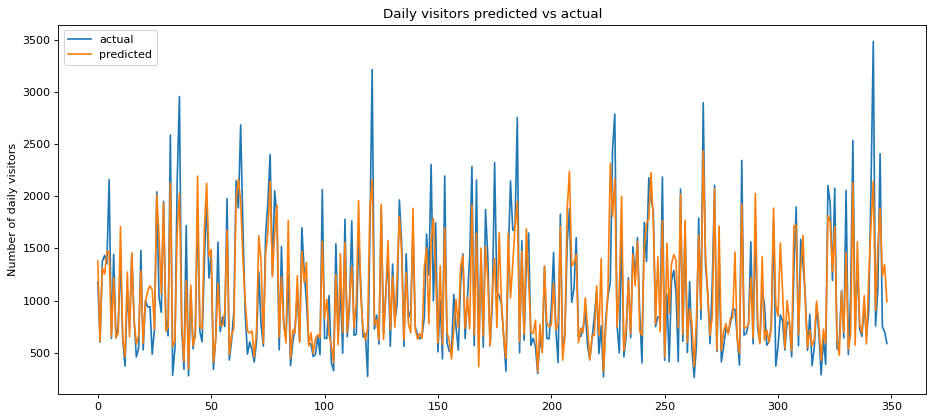

In [25]:
rfr = RandomForestRegressor(n_estimators = 50, 
                            min_samples_split = 6, 
                            min_samples_leaf = 1, 
                            max_features = 'sqrt',
                            max_depth = 100,
                            bootstrap = False)

rfr.fit(X_train, y_train)
print('='*20)
print('LinearRegression')
print(f'accuracy of train set: {rfr.score(X_train, y_train)}')
print(f'accuracy of val set: {rfr.score(X_val, y_val)}')

y_prediction = rfr.predict(X_val).round(0).astype(int)
#print model metrics
support_functions.evaluate_prediction(y_prediction,y_val)

#visualize prediction
figure(figsize=(14, 6), dpi=80)
plt.title("Daily visitors predicted vs actual")
plt.ylabel("Number of daily visitors")
plt.plot(y_val.values, label='actual')
plt.plot(y_prediction, label='predicted')
plt.legend()
plt.show()

<ol> <b>This Random Forest Regression model will be our final model because: </b>
    <li> Out of all the models we have tested before parameter tuning the Random Forest Regression was one of the most accurate.</li>
    <li> Based on the visualizations predicted trends quite accurately follow the actual trends. </li>
    <li> Model's RMSE score is significantly lower/better than the base-line linear regression model's RMSE. </li>
    <li> It is a high-variance model,but overfit a little less than the XGBoost model.</li>
</ol>

## Saving final model

In [26]:
output_file = 'timeseries_model.bin'

#save the model
with open(output_file, 'wb') as f_out:
    pickle.dump(rfr, f_out)

# ------------ Predict the daily visitor count using the model -------------

### Load test dataset and model

In [27]:
df_test = pd.read_csv("data/data_test.csv")
df_weather = pd.read_csv("data/weather.csv")
df_test_full = df_test.merge(df_weather, on='date')

# initializing support functions class
support_functions = support_functions()

In [28]:
input_file = 'timeseries_model.bin'

#load the model
with open(input_file, 'rb') as f_in:
    final_model = pickle.load(f_in)

### Prepare the dataset

In [29]:
#data preparation processes
df_test2 = support_functions.deleting_irrevelant_columns(df_test_full, "feature_8", "feature_9")
df_test3 = support_functions.missing_weather_data(df_test2, missing_value_columns)
df_test3["date"] = pd.to_datetime(df_test3["date"])
df_test3["weekend"] = (df_test3["date"].dt.day_of_week >=5).astype('int')
df_test3['annual'] = (df_test3["date"].dt.dayofyear)/365

#data engineering processes
df_test3["school_holiday"].replace(school_dict, inplace = True)
df_test3["bank_holiday"].replace(bank_dict, inplace = True)
df_test4 = support_functions.categorical_to_numerical_convert(df_test3,["school_holiday","bank_holiday"])

### Predict the test dataset's label columm / daily visitor count

In [30]:
#creating a copy of the prepared dataset
df_test_dataset = df_test4.copy()
del df_test_dataset['date']
del df_test_dataset['label']

df_test4['label_pred'] = final_model.predict(df_test_dataset).astype('int32')
df_test4.head()

,date,feature_0,feature_1,feature_2,feature_3,feature_4,feature_5,feature_6,feature_7,feature_10,label,air_humidity,air_temperature_daily_max,air_temperature_daily_mean,air_temperature_daily_min,precipitation,snow_height,sunshine_hours,wind_speed_max,weekend,annual,no_school_holiday,school_holiday_country1,school_holiday_country12,school_holiday_country2,bank_holiday_country12,bank_holiday_country2,no_bank_holiday,label_pred
0,2010-01-01,0,0,0,4.6,7.6,2.6,4.6,0,0,NaN,91.0,-1.5,-2.1,-3.3,0.2,10,0.0,7.4,0,0.002740,0,0,1,0,1,0,0,910
1,2010-01-02,0,0,0,4.6,7.6,2.6,4.6,0,0,NaN,89.0,-2.0,-3.7,-5.3,7.5,9,0.0,5.9,1,0.005479,0,0,1,0,0,0,1,1141
2,2010-01-03,0,0,0,4.6,7.6,2.6,4.6,0,0,NaN,91.0,-3.5,-4.6,-5.6,0.2,17,0.3,6.5,1,0.008219,0,0,1,0,0,0,1,1054
3,2010-01-04,0,0,0,4.6,7.6,2.6,4.6,0,0,NaN,89.0,-3.3,-4.9,-7.4,0.3,16,1.0,9.1,0,0.010959,0,0,1,0,0,0,1,1057
4,2010-01-05,0,0,0,4.6,7.6,2.6,4.6,0,0,NaN,90.0,-0.7,-1.9,-3.3,1.1,15,0.0,8.2,0,0.013699,0,0,1,0,0,0,1,1013


### Saving the test results

In [31]:
df_final_prediction = df_test4[["date","label_pred"]]
df_final_prediction.columns = ["date","label"]

#save to csv
df_final_prediction.to_csv("test_prediction.csv", index = False)

# Thank you for your time!